In [2]:
# import sqlalchemy
import sqlite3
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Connect to SQLite database
connection = sqlite3.connect(r'../data/vivino.db')
# Create a cursor object
cursor = connection.cursor()

## Specific combination of tastes

- We have detected that a big cluster of customers like a specific combination of tastes. 
- We have identified a few primary keywords that match this. 
- We would like you to find all the wines that have those keywords. 
- To ensure the accuracy of our selection, ensure that more than 10 users confirmed those keywords. 
- Also, identify the group_name related to those keywords.

Keywords:

- coffee
- toast
- green apple
- cream
- citrus

In [5]:
query_taste_count = f"""
    SELECT keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor,
           COUNT(keywords_wine.keyword_type) AS count
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
    WHERE keywords.name IN ("coffee", "toast", "green apple", "cream", "citrus") AND
          keywords_wine.count > 10
    GROUP BY group_flavor
    ORDER BY count DESC
;
"""
df_taste_count = pd.read_sql_query(query_taste_count, connection)
print(df_taste_count.shape)
display(df_taste_count)

(7, 2)


,group_flavor,count
0,coffee (oak),310
1,coffee (non_oak),310
2,cream (microbio),257
3,toast (non_oak),179
4,toast (microbio),179
5,citrus (citrus_fruit),137
6,green apple (tree_fruit),66


In [6]:
query_5_tastes = f"""
    SELECT wines.name, wines.id,
           keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
        JOIN wines on keywords_wine.wine_id = wines.id
    WHERE keywords.name IN ("coffee", "toast", "green apple", "cream", "citrus") AND
          keywords_wine.count > 10
    ORDER BY wines.id
;
"""
df_5_tastes = pd.read_sql_query(query_5_tastes, connection)
print(df_5_tastes.shape)
display(df_5_tastes.head(10))

(1438, 3)


,name,id,group_flavor
0,St. Henri Shiraz,1268,coffee (oak)
1,St. Henri Shiraz,1268,coffee (non_oak)
2,St. Henri Shiraz,1268,cream (microbio)
3,Siepi,1471,coffee (oak)
4,Siepi,1471,toast (non_oak)
5,Siepi,1471,coffee (non_oak)
6,Siepi,1471,toast (microbio)
7,Solare Toscana,1647,coffee (oak)
8,Solare Toscana,1647,coffee (non_oak)
9,Tenuta Tignanello 'Solaia',1651,coffee (oak)


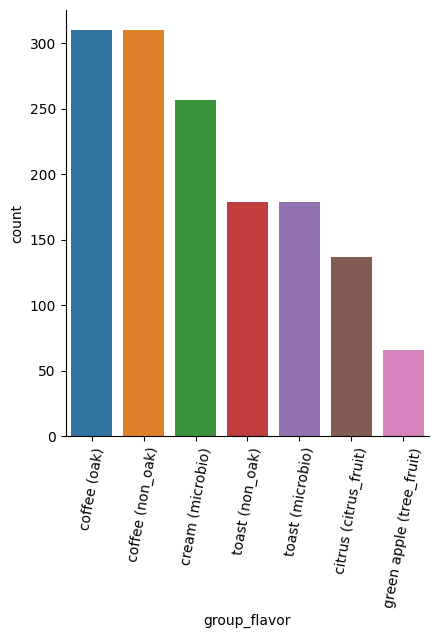

<Figure size 640x480 with 0 Axes>

In [7]:
g = sns.catplot(
	x = "group_flavor",
	data = df_5_tastes,
	kind = "count"
)
g.tick_params(axis="x", rotation=80)
plt.show()
plt.clf()